In [1]:
import sys
import os
import glob
import itk
import random
import mermaid
brain_paths = glob.glob("../../oasis/*/*/RAW/*.hdr")
import mermaid.visualize_registration_results
import matplotlib.pyplot as plt
import numpy as np

brains = [itk.GetArrayFromImage(itk.imread(b)) for b in brain_paths[200:900]]

brains = [b for b in brains]

brains = [b / np.max(b) for b in brains]

Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/democonf_settings.js

In [246]:
smolbrains = [b[::4, ::4, ::4].copy() for b in brains]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg

import numpy as np


In [3]:
import matplotlib.pyplot as plt

In [201]:
BATCH_SIZE = 64

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.num_layers = 5   
        down_channels = [2, 16, 16, 32, 64, 128]
        up_channels_out = [8, 8, 16, 32, 64]
        up_channels_in = [24, 32, 64, 128, 128] 
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])
        for depth in range(self.num_layers):
            self.downConvs.append( 
                nn.Conv3d(
                    down_channels[depth], 
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2
                )
            )
            self.upConvs.append(
                nn.ConvTranspose3d(
                    up_channels_in[depth], 
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2
                )
            )
        self.lastConv = nn.Conv3d(
            10, 3, kernel_size=3, padding=1)
        #torch.nn.init.zeros_(self.lastConv.weight)
     
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        skips = []
        for depth in range(self.num_layers):
            skips.append(x)
            x = F.relu(self.downConvs[depth](x))
        for depth in reversed(range(self.num_layers)):
            x = F.relu(self.upConvs[depth](x))
            x = torch.cat([x, skips[depth]], 1)
        x = self.lastConv(x)
        return x

class DiffUNet(nn.Module):
    def __init__(self):
        super(DiffUNet, self).__init__()
        self.num_layers = 5   
        down_channels = [2, 16, 16, 32, 64, 128]
        up_channels_out = [8, 8, 16, 32, 64]
        up_channels_in = [24, 32, 64, 128, 128]
        diff_channels_in = [10, 24, 32, 64, 128, 128]
        
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])
        self.diffConvs = nn.ModuleList([])
        for depth in range(self.num_layers):
            self.downConvs.append( 
                nn.Conv3d(
                    down_channels[depth], 
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2
                )
            )
            self.upConvs.append(
                nn.ConvTranspose3d(
                    up_channels_in[depth], 
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2
                )
            )
            self.diffConvs.append(nn.Conv3d(
                diff_channels_in[depth],
                3,
                kernel_size=3,
                padding=1,
                )
            )
            
        self.firstDiffConv = nn.Conv3d(
            128, 3, kernel_size=3, padding=1)
        #torch.nn.init.zeros_(self.lastConv.weight)
     
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        skips = []
        for depth in range(self.num_layers):
            skips.append(x)
            x = F.relu(self.downConvs[depth](x))
        diff = self.firstDiffConv(x)
        for depth in reversed(range(self.num_layers)):
            x = F.relu(self.upConvs[depth](x))
            x = torch.cat([x, skips[depth]], 1)
            diff = (
                F.interpolate(diff, scale_factor=2, mode="trilinear") 
              + self.diffConvs[depth](x)
            )
            
        #x = self.lastConv(x)
        return diff

class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([BATCH_SIZE, 1, 32, 64, 64])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
       
        
        self.regis_net = UNet().cuda()
        
    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv, self.phi1, self.spacing, 1)
        ll = 160
        regularization_loss = ll * torch.mean(
            (self.identityMap - self.fake_ident)**2)
        self.distortion_magnitude = ll * torch.mean(
            (self.identityMap - self.phi1)**2
        )
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        print(regularization_loss.detach().cpu().item(), similarity_loss.detach().cpu().item(), 
             self.distortion_magnitude.detach().cpu().item())
        
        self.all_loss = regularization_loss + similarity_loss

class FineMermaidNet(nn.Module):
    def __init__(self, coarseNet):
        super(MermaidNet, self).__init__()
        
        self.coarseNet = coarseNet
        
        self.sz = np.array([BATCH_SIZE, 1, 128, 256, 256])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
       
        
        self.regis_net = UNet().cuda()
        
    def mapTwoImages(moving_image, fixed_image):
        pass
        

    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv, self.phi1, self.spacing, 1)
        ll = 160
        regularization_loss = ll * torch.mean(
            (self.identityMap - self.fake_ident)**2)
        self.distortion_magnitude = ll * torch.mean(
            (self.identityMap - self.phi1)**2
        )
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        print(regularization_loss.detach().cpu().item(), similarity_loss.detach().cpu().item(), 
             self.distortion_magnitude.detach().cpu().item())
        
        self.all_loss = regularization_loss + similarity_loss


net = MermaidNet()
0

0

In [203]:
optimizer = torch.optim.Adam(net.parameters(), lr=.0005)

In [204]:
net.train()

MermaidNet(
  (regis_net): UNet(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose3d(24, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ConvTranspose3d(32, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): ConvTranspose3d(64, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))


In [256]:
def make_batch():
    image = np.array([random.choice(brains)[::4, ::4, ::4] for _ in range(BATCH_SIZE)])
    image = image.reshape(BATCH_SIZE, 1, 32, 64, 64)
    image = torch.tensor(image).cuda()
    return image
for _ in range(10):

    moving_image = make_batch()
    fixed_image = make_batch()
    optimizer.zero_grad()
    net(moving_image, fixed_image)
    loss = net.all_loss

    loss.backward()
    optimizer.step()


0.0023004410322755575 0.01826600357890129 0.05963699519634247
0.002489191945642233 0.01894495263695717 0.062498293817043304
0.0029409462586045265 0.01849014312028885 0.06723347306251526
0.002837198553606868 0.016599657014012337 0.05278322100639343
0.0025993352755904198 0.017783155664801598 0.05265354365110397
0.0023032790049910545 0.017405297607183456 0.061531104147434235
0.002329458948224783 0.017991406843066216 0.05828974395990372
0.0024845239240676165 0.016817472875118256 0.055335722863674164
0.002472691237926483 0.0177232027053833 0.060343459248542786
0.0025177602656185627 0.017663318663835526 0.06400308758020401


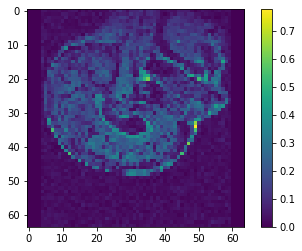

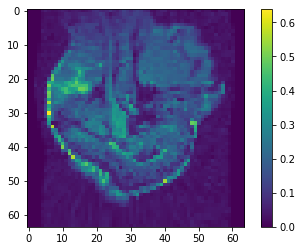

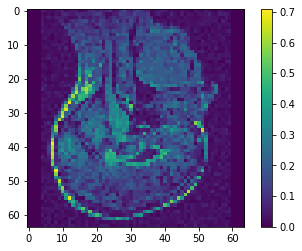

In [258]:
N += 1
plt.imshow(moving_image[N, 0, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, 16].cpu())
plt.colorbar()

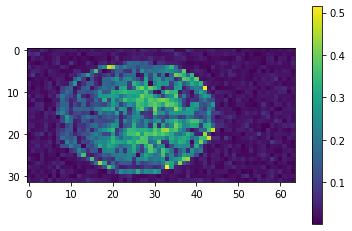

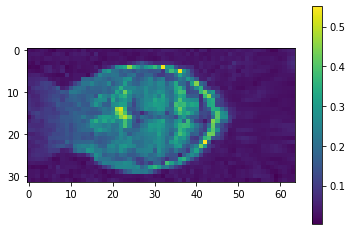

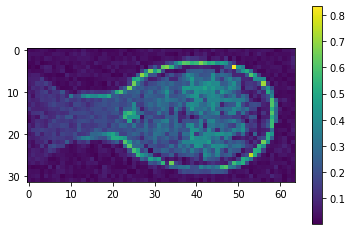

In [259]:
plt.imshow(moving_image[N, 0, :, :, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, :, :, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, :, :, 16].cpu())
plt.colorbar()

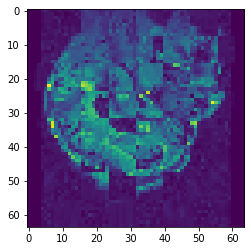

In [260]:

plt.imshow(mermaid.visualize_registration_results.checkerboard_2d(
    net.warped_fixed_image[N, 0, 14].detach().cpu(),
    moving_image[N, 0, 14].cpu()))

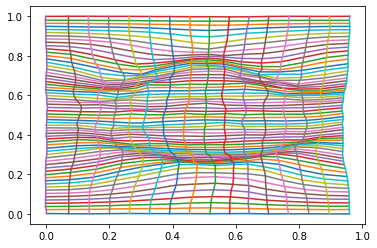

In [265]:
def grid(A, B):
    #plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))
    
def grd(d):
    grid(d[0], d[2])
    
grd(net.phiinv[N, :, ::2, 16].detach().cpu())
plt.scatter

In [262]:
def get_phi(a, b):
    net(a, b)
    return net.phi1.detach().cpu()

In [234]:
phi2 = get_phi(fixed_image, moving_image)
phi1 = get_phi(moving_image, fixed_image)


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.0024307610001415014 0.01728900521993637 0.05462070554494858
0.0023985663428902626 0.01728900708258152 0.054317656904459


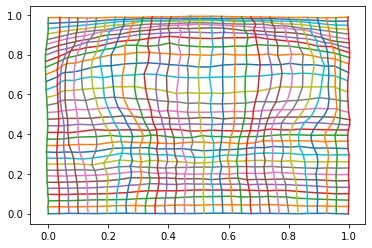

In [235]:
grd(phi1[N, :, :, ::2, 16])

In [236]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


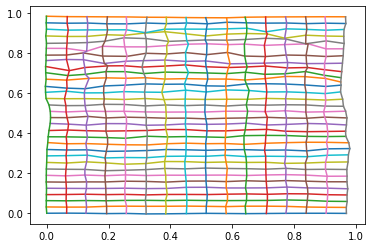

In [226]:
grd(ident_hope[N, :, ::2, ::2, 30])

In [52]:
net.regis_net = rnet

In [285]:
A = torch.tensor([[[[0, 1, 0,], [0., 0, 0]]]])

torch.sum(F.interpolate(A, scale_factor=2, mode="bilinear", align_corners=True))

tensor(4.8000)

In [ ]:
B = torch.tensor([[[1, 2, 1],[2, 4, 2], [1, 2, 1]]])
B = B / torch.sum(B)

In [241]:
torch.save(net.state_dict(), "wednesday_headaligner2")

In [11]:
net.load_state_dict(torch.load("good head aligner"))

AttributeError: 'function' object has no attribute 'copy'

In [10]:
torch.load("goodheadaligner")

<bound method Module.state_dict of MermaidNet(
  (regis_net): UNet(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose3d(24, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ConvTranspose3d(32, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): ConvTranspose3d(64, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), st

In [144]:
ls -l

total 944876
drwxr-xr-x 3 tgreer compsci        27 Oct 17 00:39  files/
-rw-r--r-- 1 tgreer compsci 474508958 Oct 19 18:05  goodheadaligner
-rw-r--r-- 1 tgreer compsci   4847550 Oct 21 14:35 'good headaligner'
-rw-r--r-- 1 tgreer compsci 474508958 Oct 19 09:56 'good head aligner'
-rw-r--r-- 1 tgreer compsci      1521 Oct 16 00:24  mermaid_config2.json
-rw-r--r-- 1 tgreer compsci      2258 Oct 16 00:24  mermaid_config.json
-rw-r--r-- 1 tgreer compsci       480 Oct 16 00:24  mermaid_config_svf.json
-rw-r--r-- 1 tgreer compsci   3831669 Oct 16 00:24 'MNIST pytorch.ipynb'
-rw-r--r-- 1 tgreer compsci    126593 Oct 16 00:24  Registration.ipynb
-rw-r--r-- 1 tgreer compsci    209162 Oct 16 00:24  Registration-NN.ipynb
-rw-r--r-- 1 tgreer compsci    656576 Oct 21 16:42  Registration-NN-nosolver-Brains.ipynb
-rw-r--r-- 1 tgreer compsci   1249275 Oct 21 16:20  Registration-NN-nosolver-Brains-multiscale.ipynb
-rw-r--r-- 1 tgreer compsci    929624 Oct 21 16:17  Registration-NN-nosolver.ipynb
-rw-r-

In [206]:
net.load_state_dict(torch.load("wednesday_headaligner"))

<All keys matched successfully>

In [247]:
torch.__version__

'1.4.0'